In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def recirculate(inputs, w1, w2, lr=1, reg=0.75, update=True):
    # Initialize neuron activations for each input & time step
    # One visible layer
    v = np.ones((inputs.shape[0], 2, 5))
    # One hidden layer
    h = np.ones((inputs.shape[0], 2, 3))
    
    # Activation functions
    def logistic(x):
        return 1 / (1 + np.exp(-x))
    
    def relu(x):
        return np.maximum(0, x)
    
    
    # First forward pass (t=0)
    v[:, 0, :-1] = inputs
    h[:, 0, :-1] = np.tanh(v[:, 0, :] @ w1)
    
    # Recirculation (t=1)
    v[:, 1, :-1] = reg * v[:, 0, :-1] + (1 - reg) * relu(h[:, 0, :] @ w2)
    h[:, 1, :-1] = np.tanh(v[:, 1, :] @ w1)
    
    # Calculate weight updates
    dw1 = lr * v[:, 1, :].T @ (h[:, 0, :-1] - h[:, 1, :-1])
    dw2 = lr * h[:, 0, :].T @ (v[:, 0, :-1] - v[:, 1, :-1])
    
    return w1 + dw1, w2 + dw2, v[:, 1, :-1], h[:, 0, :-1]

In [56]:
# Visible to hidden weights
w1 = np.random.random((5, 2)) - 0.5
# Hidden to visible weights
w2 = np.random.random((3, 4)) - 0.5

# Input batch
inps = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

# Error for each epoch
error = np.empty(100)

# Train!
for i in range(100):
    _, _, v_out, _ = recirculate(inps, w1, w2, lr=0, reg=0, update=False)
    error[i] = 0.5 * ((inps - v_out) ** 2).sum()    
    
    w1, w2, _, _ = recirculate(inps, w1, w2, lr=1, reg=0.75, update=True)

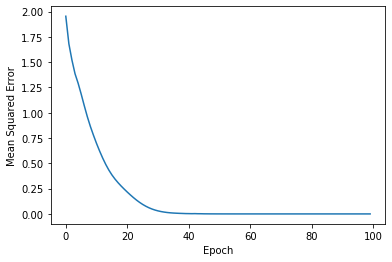

In [57]:
# Plot error
fig = plt.figure()
ax = fig.subplots(1, 1)
ax.plot(error)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
plt.show()

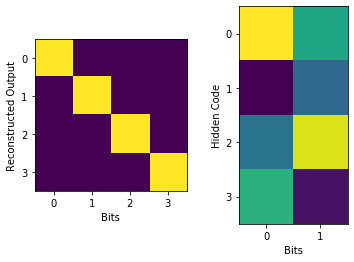

In [60]:
# Check the coded representation it learned
_, _, v_out, h_out = recirculate(inps, w1, w2, lr=0, reg=0, update=False)
fig = plt.figure()
axes = fig.subplots(1, 2)
axes[0].imshow(v_out)
axes[0].set_ylabel('Reconstructed Output')
axes[0].set_xlabel('Bits')
axes[0].set_yticks([0, 1, 2, 3])
axes[0].set_yticks([0, 1, 2, 3])
axes[1].imshow(h_out)
axes[1].set_ylabel('Hidden Code')
axes[1].set_xlabel('Bits')
axes[1].set_yticks([0, 1, 2, 3])
axes[1].set_xticks([0, 1])
plt.show()